Welcome! This tutorial will walk you through the basics of using SpinSpotter to identify stellar rotation in photometric light curve data.

In [1]:
# Imports
# library import
import rotation_library_github as rl

# dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit

# support stuff
import time
import os
import importlib


In [345]:
# DELETE LATER
importlib.reload(rl)

<module 'rotation_library_github' from '/Volumes/GoogleDrive-104247596127147150032/My Drive/Research/rotation/github/rotation_library_github.py'>

In [3]:
# # FIX LATER
# # Define paths
# # Last updated 5/12/2020: need to check the file path works for external drive

# # # paths for mac + external drive
# general_path = rl.general_path
# file_path = general_path+'github_tutorial_data/'


# 1. Download or import data 

SpinSpotter uses the [LightKurve](https://docs.lightkurve.org/index.html) package to handle light curve data. You can either use it to download light curves directly from the MAST database, or else open local files on your computer and convert them to LightKurve objects. Each sector (or quarter) of data should be stored as a separate LightCurve object, and all the sectors of the same star should be stored in a [LightCurveCollection](https://docs.lightkurve.org/reference/api/lightkurve.LightCurveCollection.html) object.

__Option 1: Search and download data using LightKurve.__

Here we use LightKurve's built in functions to download data for a TESS target (TIC 149626644).

SearchResult containing 9 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 01 2018   SPOC     120   149626644      0.0
  1 TESS Sector 02 2018   SPOC     120   149626644      0.0
  2 TESS Sector 03 2018   SPOC     120   149626644      0.0
  3 TESS Sector 05 2018   SPOC     120   149626644      0.0
  4 TESS Sector 06 2018   SPOC     120   149626644      0.0
  5 TESS Sector 08 2019   SPOC     120   149626644      0.0
  6 TESS Sector 09 2019   SPOC     120   149626644      0.0
  7 TESS Sector 12 2019   SPOC     120   149626644      0.0
  8 TESS Sector 13 2019   SPOC     120   149626644      0.0


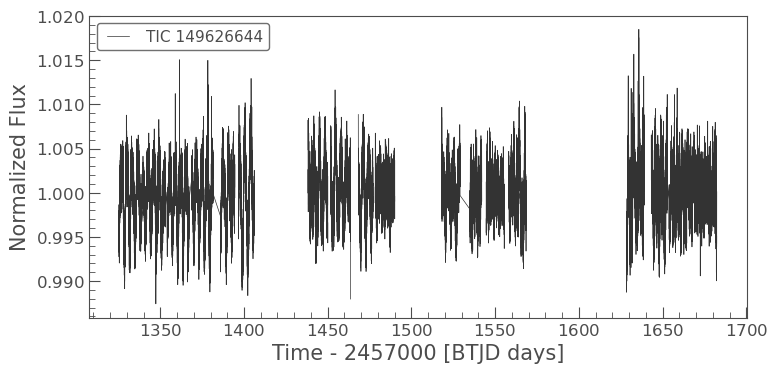

In [4]:
# Option 1: Search and download data using LightKurve.

# TIC 149626644, TESS Sectors 1-8
search_result = lk.search_lightcurve('TIC 149626644', mission='TESS', cadence='short', author='SPOC')
print(search_result)

# Download
collection = search_result.download_all()
# Plot, to make sure it looks correct
collection.stitch().plot()
plt.show()

We will also download data for a Kepler target (HD 183298).

SearchResult containing 4 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 14 2012 Kepler    1800 kplr012258514      0.0
  1 Kepler Quarter 15 2013 Kepler    1800 kplr012258514      0.0
  2 Kepler Quarter 16 2013 Kepler    1800 kplr012258514      0.0
  3 Kepler Quarter 17 2013 Kepler    1800 kplr012258514      0.0


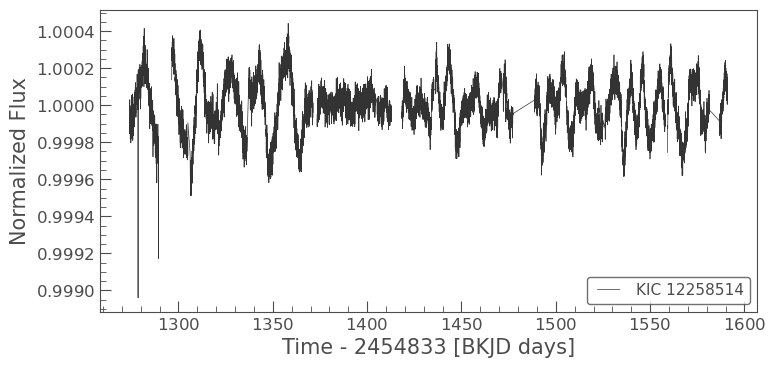

In [5]:
# HD 183298, Kepler Quarters 14-17
kepler_search_result = lk.search_lightcurve('HD 183298', mission='Kepler', exptime=1800, quarter=[14, 15, 16, 17])
print(kepler_search_result)

# Download
collection_kepler = kepler_search_result.download_all()
# Plot, to make sure it looks correct
collection_kepler.stitch().plot()
plt.show()

__Option 2: Open local files__

Here we have multiple sectors of the same star stored in a single directory (in this case, the github_tutorial_data directory.) Each sector of data is stored in a separate FITS file, but all the sectors for the same star are in the same directory. We will open each file, convert it to a LightCurve object, and then 
combine all the LightCurves a single LightCurveCollection object.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

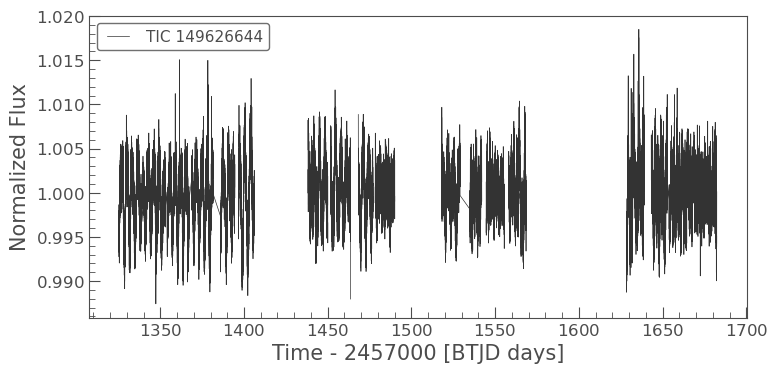

In [6]:
# Option 2: Open local files
file_array = []   # array that will hold the light curve object for each individual sector.
directory = './github_tutorial_data/TESS/tess149626644-0120-s/'  # directory which the fits files are stored it

# iterate through to open the file for each sector
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        file_array.append(lk.read(f))

# Stitche the array into a LightCurveCollection object
collection = lk.LightCurveCollection(file_array)

# Plot, to make sure that it looks correct.
collection.stitch().plot()

# 2. Process the data 

When working multisector data, we want to analyze each sector separately, as well as the combined light curve with all the data. 

The bulk of the analysis happens via `process_LightCurve()` function. This function takes in the raw data, then

1. Applies a cleaning function to the data. By default, it will use the `default_cleaning_func()`, but you can also pass a custom cleaning function as well.
2. Calculates the autocorrelation function (ACF).
3. Generates an initial estimate (pgi) of the rotation period. By default, this will use the value found from the tallest peak in a Fast Fourier Transform of the ACF, but you can also pass a custom function to do this.
4. Fit parabolas to the regions in the ACF around the pgi to refine the period value found.
5. Return a dictionary of the fit parameters.

`process_LightCurve()` returns two dictionaries. The first, which we call the fits_result, contains data arrays for the original light curve, the cleaned light curve, and the ACF. The second, which we call process_result, contains information on the various descriptive parameters calculated from the parabola fits to the ACF.

The examples below demonstrate the different options built into  `process_LightCurve()`.

## Example 1: Basic Example

Here we use `process_LightCurve()` to analyze a single light curve from our collection, using all defaults. The `bs` keyword (which stands for 'binsize') sets the cadence you would like to bin the LC to and is given in units of seconds. By default, it is set to 30 minutes.

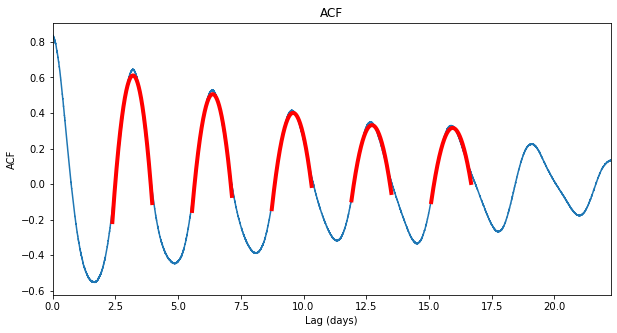

In [346]:
# grab the first light curve in the collection
lc = collection[0]

# process_LightCurve is where the bulk of the processing takes place
fits_result, process_result = rl.process_LightCurve(lc, bs=120)

# plot our results, setting the show_peaks keyword to True to check how our parabola fits looks
rl.plot_acf(fits_result, process_result, plot_peaks=True)

How do we interpret these results? Let's print a summary of the statistics.

In [154]:
# print a summary of our statistics
rl.print_summary(fits_result, process_result, bs=120)

Target: TIC 149626644
Sector/Quarter: 1
pgi: 0.004
A_avg: 0.433
B_avg: 0.451
Rsq_avg: 0.995
P_avg (days): 3.214
P_error (days): 0.007
HWHM error (days): 0.512



The summary tells us:

* The __pgi__, or the 'initial guess' of where SpinSpotter is going to try looking for a the rotation period in units of days. If this is way off, consider writing a [custom pgi-finding function](##Example-4:-Creating-a-custom-pgi-finding-function).

* __A_avg__, the average height of the parabolas fitted to the ACF. A_avg ranges from 0 to 1, with higher values indicating a stronger signal at that period. Acceptable values will vary from data set to data set, but when analyzing TESS sectors I use A_avg > 0.1 as a baseline for finding rotators.

* __B_avg__, the fractional width of the parabolas fitted to the ACF at the zero crossing, relative to the rotation period. B_avg ranges from 0 to inf (technically most will have values below 1). Acceptable values will  be close to 0.5, since this indicates that the width of the peaks at the zero crossing is equal to about half the rotation period, and thus that the ACF is more sine-wave-like, as we would expect if a strong periodic signal is present. Values close to 0 indicate that the peak is very narrow and covers only a small fraction of the phase. Values close to 1 indicate very broad, flat peaks.

* __Rsq_avg__, the goodness of fit metric for the parabolas fitted to the ACF. Rsq_avg ranges from 0 to 1, with higher values indicating a better fit to the ACF, and thus more reliable values for the other fitted parameters. Acceptable values will vary from data set to data set, but when analyzing TESS sectors I use Rsq_avg > 0.9 as a baseline for finding rotators.

* __P_avg__, the rotation period in days, as cacluated from the average vertex location of the parabolas fitted to the ACF. 

* __P_err__ and __HWHM_err__, two different metrics for the rotation period error in days. If SpinSpotter is able to fit parabolas to three or more peaks in the ACF, then P_err is the standard deviation of the vertex locations of those parabolae. Otherwise, it defaults to the same value as HWHM, which is the average half-width-half-max of the fitted parabolas. The HWHM tends to be a much more conservative estimate of the error.


## Example 2: Applying a Transit Mask

We can also ask the default cleaning function to mask out transit events, which it does using the [create_transit_mask()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.create_transit_mask.html) function from LightKurve. To do this, pass an array of transit paramters like `[period (days), epoch (BJD), duration (days)]` in units of days to the `transit` keyword. Each entry can be an array if there are multiple planets.

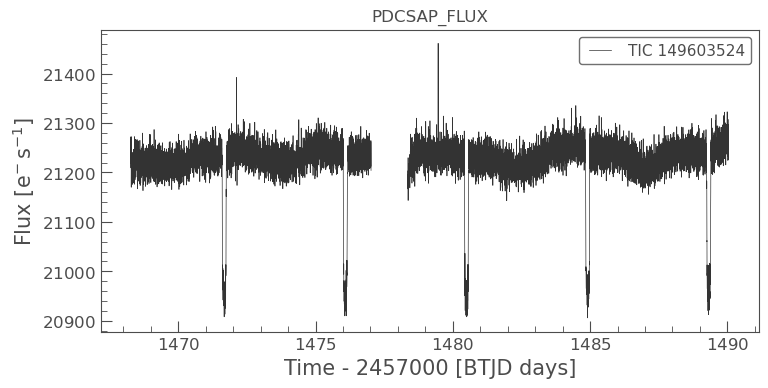

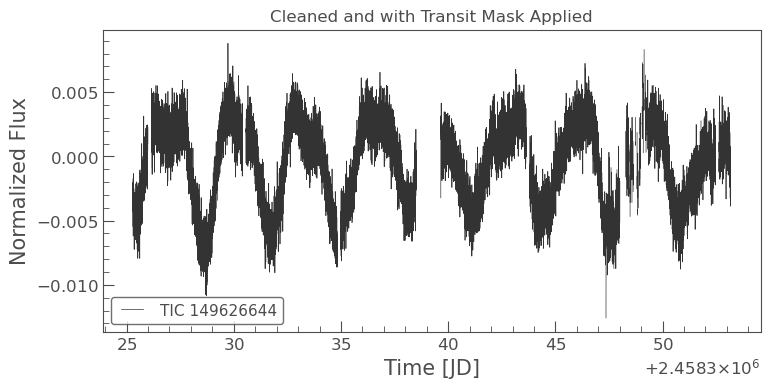

In [213]:
# Transit Masking Example

# TIC 149626644, aka TOI 102, sector 6
# Download a sector
lc_toi = lk.search_lightcurve('TIC 149603524', sector=6, mission='TESS', cadence='short', author='SPOC').download()

# Download
lc_toi.plot()
plt.title('PDCSAP_FLUX')
plt.show()

# apply a transit mask using the default_cleaning_function
# transit array takes the form [period (days), epoch (BJD), duration (days)]
transit = [4.41195, 2459384.943122, 3.894/24]

lc_masked = rl.default_cleaning_func(lc, bs=120, transit=transit)
lc_masked.plot()
plt.title('Cleaned and with Transit Mask Applied')
plt.show()

See how much cleaner our ACF looks with transit events removed!

<Figure size 432x288 with 0 Axes>

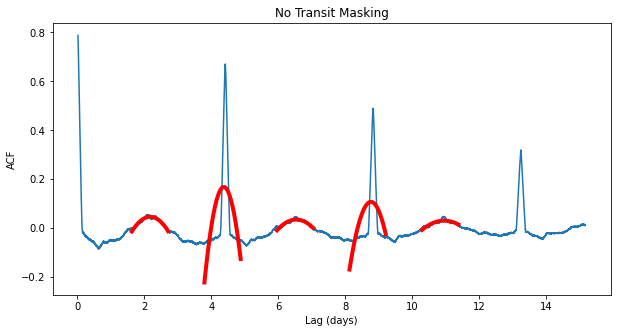

<Figure size 432x288 with 0 Axes>

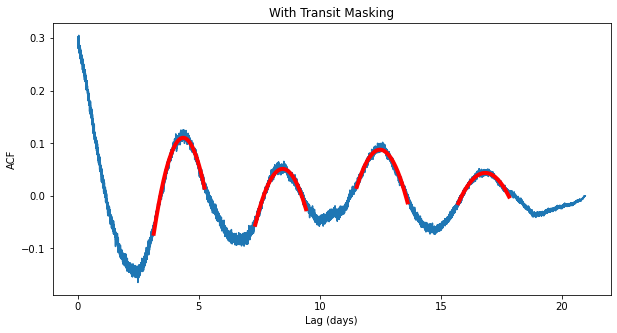

In [12]:
# Without transit mask
fits_result, process_result = rl.process_LightCurve(lc_toi, bs=120)
rl.plot_acf(fits_result, process_result, plot_peaks=True)
plt.title('No Transit Masking')
plt.show()

# With transit mask
fits_result, process_result = rl.process_LightCurve(lc_toi, bs=120, transit=transit)
rl.plot_acf(fits_result, process_result, plot_peaks=True)
plt.title('With Transit Masking')
plt.show()

In [13]:

# print a summary of our statistics
rl.print_summary(fits_result, process_result, bs=120)

Target: TIC 149603524
Sector/Quarter: 6
pgi: 0.006
A_avg: 0.073
B_avg: 0.445
Rsq_avg: 0.988
P_avg (days): 4.248
P_error (days): 0.047
HWHM error (days): 0.667



## Example 3: Using a custom cleaning function (NOTE: CURRENTLY BROKEN)

You can also create a custom cleaning function which will be applied to the light curve before the ACF is calculated. A custom cleaning function must:
1. Take a LightCurveObject as input and return one as the output.
2. The returned LC must have even cadence and be normalized to center around zero.

Here, we create a custom cleaning function which applies a sigma clip, but you can write your own to perform more complex operations as well.

<AxesSubplot:xlabel='Time [JD]', ylabel='Normalized Flux'>

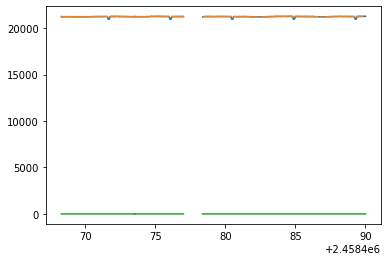

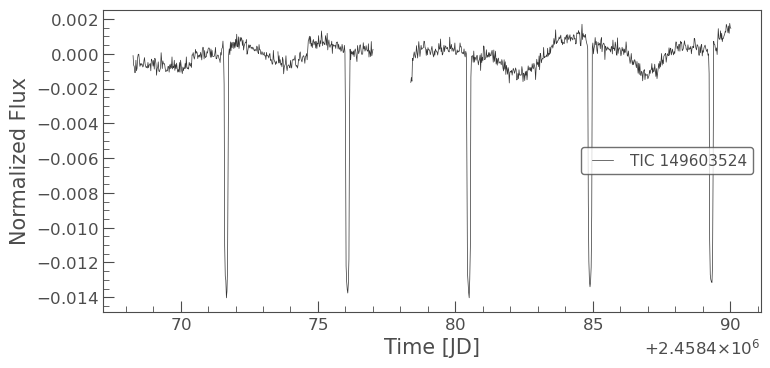

In [168]:
# Define your custom cleaning function
def custom_cleaning_func(lc, bs=30*60, kwargs={}):
    """Given a lightkurve lc, applies the desired cleaning to it. Returns a lightkurve lc object.
    Inputs:
        lc -- a light curve file
        binsize -- cadence to bin to in seconds, default is 30 minutes
        kwargs -- same as for astropy.stats.sigma_clip
    Outputs:
        a light curve file with the desired cleaning applied
        """
    # adjust date format for clarity
    lc.time.format = 'jd'
        
    # apply binning
    time_bin, flux_bin = rl.bin_lc(lc.time.value, lc.flux.value, bs=bs)

    # Now do whatever custom stuff you want to do! 
    # Here, we will apply a simple sigma clipping function
    from astropy.stats import sigma_clip
    flux_clip = sigma_clip(flux_bin, masked=True, **kwargs)
    
    plt.plot(time_bin, flux_bin)
    plt.plot(time_bin, flux_clip)
#     plt.plot(lc.time.value, flux_clip)
#     print(len(lc.time.value), len(flux_clip))
       
    # reconstruct light curve object and normalize to center around zero
    
    # THIS STEP APPEARS TO IGNORE THE SIGMA CLIPPING AND I DON'T KNOW WHY
    lc_clean = lk.LightCurve(time=time_bin, flux=flux_clip, meta=lc.meta).normalize() - 1
    
    plt.plot(lc_clean.time.value, lc_clean.flux.value)

    return lc_clean

kwargs = {'sigma':2}
lc_clean = custom_cleaning_func(lc_toi, bs=30*60, kwargs=kwargs)
lc_clean.plot()

# from astropy.stats import sigma_clip
# plt.plot(sigma_clip(lc_toi.flux.value, masked=True, sigma=3))


Now apply it to a star that has several large transit events and plot to appreciate the results!

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

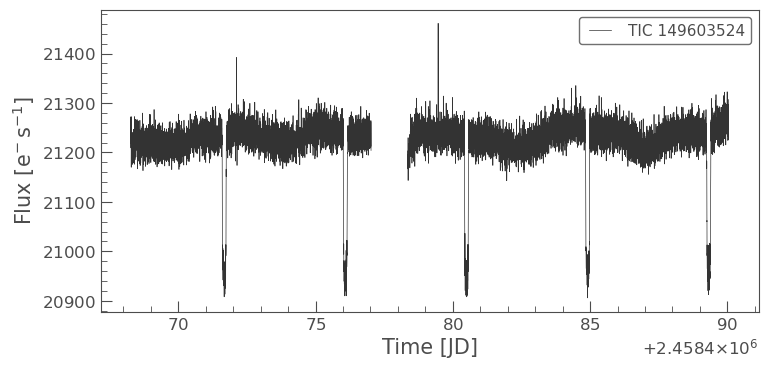

In [17]:
fits_result_default.keys()
lc_toi.plot()

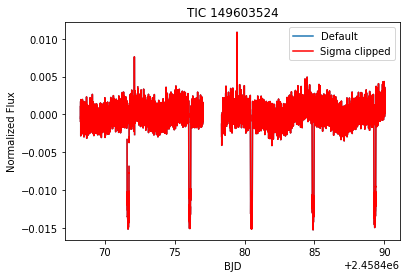

In [24]:
# Now compare the light curves with the custom and the default cleaning flunctions applied

# Default version
fits_result_default, process_result_default = rl.process_LightCurve(lc_toi, bs=120)

# custom sigma clip version
# define the kwargs
cleaning_func_kwargs = {'sigma':2}
fits_result_custom, process_result_custom = rl.process_LightCurve(lc_toi, bs=120, 
                                            cleaning_func=custom_cleaning_func,
                                            cleaning_func_kwargs=cleaning_func_kwargs)

# plot!
plt.plot(fits_result_default['time_even'], fits_result_default['lc_even'], label='Default')

plt.plot(fits_result_custom['time_even'], fits_result_custom['lc_even'], label='Sigma clipped',c='r')

plt.legend()
plt.xlabel('BJD')
plt.ylabel('Normalized Flux')
plt.title(lc_toi.meta['OBJECT'])
plt.show()

## Example 4: Creating a custom pgi-finding function

Simiarly, we can also write custom functions on how to select the the "initial guess" for the period (`pgi`), which directs where in the ACF the parabola fitting function will start searching for the rotation period. Here we give a very simple example, which allows the user to input a decimal number in units of days to be used as the pgi.

The `custom_calc_pgi()` function must:
1. Take the acf and bs (binsize) keyword as inputs.
2. Return two arguments. The first is a float which givens the `pgi` **in unit of acf lags**. The second is a results dictionary of other relevant information, such as whether the function successfully found a valid `pgi`.

A custom pgi-finding function can be useful when fast-Fourier transform is doing a poor job identifying the rotation signal in the ACF. This can happen when there are multiple periodic signals present in the time series, in which case you may want to use a pgi-finding function that selects a peak other than the highest one in the FFT, or uses a different method entirely.

In [163]:
# define the custom function
def custom_calc_pgi(acf, bs=30*60, pgi_in_days=-1):    
    """
    docstring. The default pgi-finding funciton, using the FFT of the acf.
    Inputs: acf - and acf
    
    Outputs: pgi - the index in the acf of the initial period guess in units of lags
             results - dictionary of other relevant paramters from the pgi-finding code
    """
    results = {}
    pgi = int(np.round(rl.days_to_bins(pgi_in_days, bs=bs)))
    
    # if the pgi is nan or is negative, then fail
    if (np.isnan(pgi)) or pgi < 0 :
        results['fail'] = True
        return np.nan, results
    else:
        results['fail'] = False
    
    return pgi, results

In [169]:
# Apply custom function
# custom sigma clip version
# define the kwargs
prot_prior_func_kwargs = {'pgi_in_days':4.2}
fits_result_custom, process_result_custom = rl.process_LightCurve(lc_toi, bs=120, 
                                            prot_prior='custom', prot_prior_func=custom_calc_pgi, 
                                            prot_prior_func_kwargs=prot_prior_func_kwargs)

# Default version
fits_result_default, process_result = rl.process_LightCurve(lc_toi, bs=120)

# print(process_result_custom['pgi'])
# print(process_result_default['pgi'])
# print(rl.days_to_bins(4.2,bs=120))

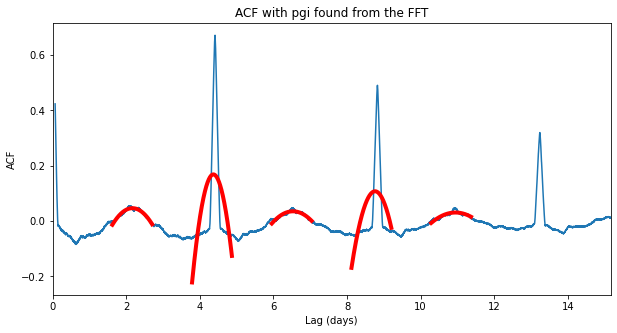

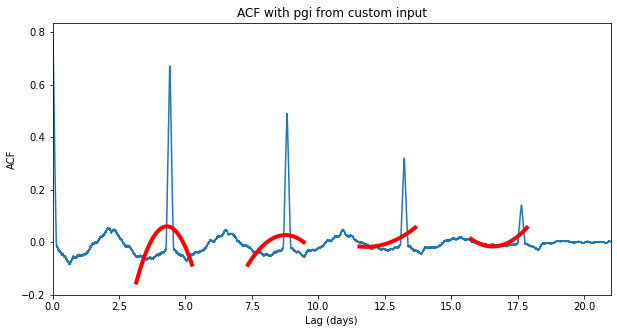

In [170]:
# Plot the results and compare
rl.plot_acf(fits_result_default, process_result, plot_peaks=True, cut=50)
plt.title('ACF with pgi found from the FFT')
plt.show()
rl.plot_acf(fits_result_custom, process_result_custom, plot_peaks=True)
plt.title('ACF with pgi from custom input')
plt.show()

Notice that we have now forced SpinSpotter to fit parabolae in different regions... hey, I didn't promise it'd be better, just that you could do it! ;)


## Example 5: Running a multisector target

SpinSpotter can also take in multiple chunks of data (such as TESS sectors or Kepler quarters) and process them together. We recommend storing all the sectors in the same LightCurveCollection object, which makes it easy to stitch and then process the light curve like any other target. We will use TIC 149626644, which we downloaded earlier, as an example.

First, we need to stitch the collection into a single light curve. This can be done simply with the [stitch()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurveCollection.stitch.html#lightkurve.LightCurveCollection.stitch) funciton from the LightKurve package, or with a more complex treatment. Our preferred method is to:

1. Normalize each sector separately by dividing by its median value.
2. Concatenating the sectors together.
3. Bin the combined light curve to even cadence.
4. Subtracting the mean of the entire combined light curve so that it is centered around zero.

This final step is important because it ensures that the mean of the light curve is zero, and thus the mean value will not be affected when we fill the data gaps with zero values later later, which will also reduce the impact when we calculated the ACF later.

Note: If there are any further operations you want perform on each sector of data separately, it should be done at this step, _before_ stitching the sectors together.

In [333]:
importlib.reload(rl)

<module 'rotation_library_github' from '/Volumes/GoogleDrive-104247596127147150032/My Drive/Research/rotation/github/rotation_library_github.py'>

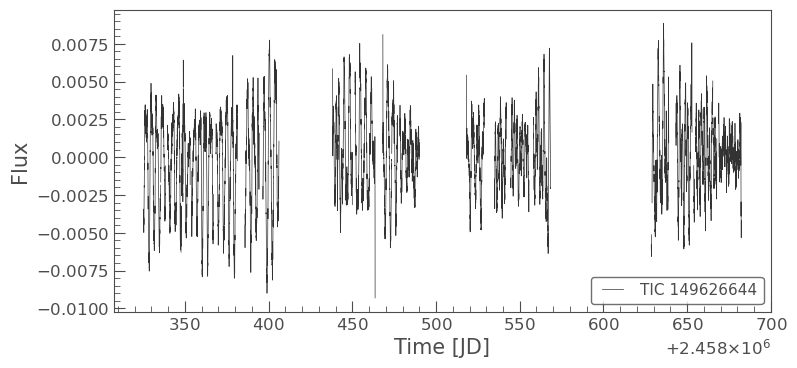

In [330]:
# Preparing a multisector LC from a LightCurveCollection object
def median_normalize(lc):
    """Normalizes a light curve by dividing by its median flux value. Returns a light curve object."""
    lc_norm = lc.copy()
    lc_norm.flux /= np.nanmedian(lc.flux.value)
    lc_norm.flux_err /= np.nanmedian(lc.flux.value)
    return  lc_norm

# set binsize to 30 minutes
bs = 30*60

# Step 1 & 2: Normalize and concatentate
lc_stitched = collection.stitch(corrector_func=median_normalize)

# Step 3: Bin to even cadence.
time, flux, flux_err = rl.bin_lc(lc_stitched.time.value, lc_stitched.flux.value, 
                       flux_err=lc_stitched.flux_err.value, bs=bs)
lc_clean = lk.LightCurve(time=time, flux=flux, flux_err=flux_err, meta=lc.meta)    

# Step 4: Subtract the mean of the stitched LC
lc_clean.flux = lc_clean.flux.value - np.nanmean(lc_clean.flux.value)

# plot and see how it looks!
lc_clean.plot()
# plt.xlim([time[0], time[10000]])
plt.show()


In the cell above, we showed these steps explicitly, but you can get the exact same functionality by calling the `prep_LightCurveCollection()` function!

[1, 2, 3, 5, 6, 8, 9, 12, 13]


<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

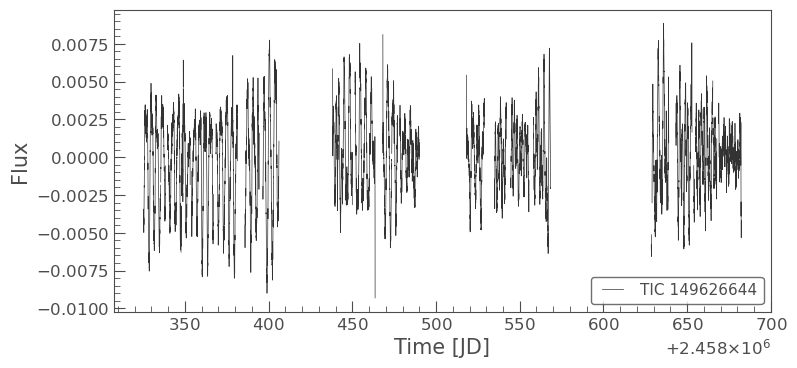

In [331]:
# Clean and stitch the collection using the built-in prep_LightCurveCollection() funtion
lc_clean = rl.prep_LightCurveCollection(collection, bs=30*60)

lc_clean.plot()

Now we have taken a LightCurveCollection object and turned it into a single LC object which has been normalized, binned, and stitched together.

Next we can process our multisector LC with the `process_LightCurve()`. Since we have already normalized and binned the LC to even cadence, we will set the `precleaned` keyword to True. (If we don't do this, the function will attempt to re-normalize the light curve again.)

Target: TIC 149626644
Sector/Quarter: 13
pgi: 0.000
A_avg: 0.460
B_avg: 0.425
Rsq_avg: 0.984
P_avg (days): 0.221
P_err (days): 0.002
HWHM_err (days): 0.033



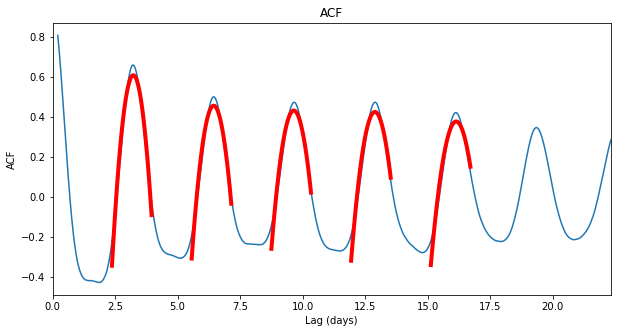

In [324]:
# Use process_LightCurve() with precleaned=True
# process_LightCurve is where the bulk of the processing takes place, with binsize set to 30 minutes
fits_result, process_result = rl.process_LightCurve(lc_clean, bs=bs, precleaned=True)

# plot our results, setting the show_peaks keyword to True to check how our parabola fits looks
rl.plot_acf(fits_result, process_result, plot_peaks=True)

# print summary
rl.print_summary(fits_result, process_result, bs=120)

# 3. Evaluating the results

Now that we have run a few light curves, let's look closely at the information we got back and how to interpret it. `process_LightCurve()` returns two dictionaries, the `fits_result` and the `process_result`. The `fits_result` dictionary contains the data and information of the light curve and the acf itself, whereas the `process_result` contains information about the parabola fits, the descriptive parameters, and the found rotation period.

The `fits_result` dictionary contains the following keys:
- __ID__ - (int) the TICID or KICID of the target
- __OBJECT__ - (str) the name of the target, e.g. 'TIC 149626644'
- __SECTOR__ - (int or arr) the sector or quarter of the data. This may be an array if this is a multi-sector light curve.
- __time_raw__ - (arr) the timestamps of the raw, unprocessed light curve
- __flux_raw__ - (arr) the fluxes of the raw, unprocessed light curve
- __flux_err_raw__ - (arr) the flux errors of the raw, unprocessed light curve
- __time_even__ - (arr) the timestamps of the cleand and binned light curve
- __flux_even__ - (arr) the fluxes of the cleand and binned light curve
- __flux_err_even__ - (arr) the flux errors of the cleand and binned light curve
- __acf_lags__ - (arr) the lags of the ACF, in units of days
- __acf__ - (arr) the values of the ACF corresponding with __acf_lags__
- __acf_smooth__ - (arr) the smoothed ACF, if an argument for the `smooth` keyword is provided

The `process_result` dictionary contains the following keys, when the default settings are used:
- __smooth__ - (int) the width of the gaussian to be used in smoothing the acf, if one is provided
- __fft__ - (1D arr) the values of the fast-Fourier transform taken of the ACF in order to find the dominant periodicity in the ACF
- __fft_period__ - (1d arr) the period array in units of ACF lag number of the fast-Fourier transform taken of the ACF
- __fft_period_days__ - (1d arr) the period array in units of days of the fast-Fourier transform taken of the ACF
- __pgi__ - (int) the index in the acf_lags array of the period with the highest peak in the FFT, which will be used to guide the parabola fitting to the ACF
- __fft_pgi__ - (int) the index in the fft_period array associated with the highest peak in the FFT
- __fft_prom__ - defunct
- __fail__ - (bool) indicates whether or not the pgi-finding function was able to identify a valid pgi for the target. Is set to True the function failed to find a suitable pgi, False if it was successful.
- __max_peaks__ - (1D array) the indices of the five highest peaks in the FFT, in descending order.
- __peak_heights__ - (1D array) the heights of the five highest peaks in the FFT, in descending order.
- __pgi_prom__ - (float) the peak prominence of the highest peak in the FFT, as calculated by `fft_find_peaks()`.
- __fitted_parabola_k__ - (2D array) the y values of the the fitted parabolas for each peak in the ACF. The _k_ th entry along the 0th axis corresponds to the _k_ th peak in the ACF.
- All keys ending in the suffix `_k` are arrays containing information on each individual parabola fitted to the peaks in the ACF. The _k_ th entry in the array corresponds to the _k_ th peak in the ACF.
    - __a_k__, __b_k__, and __c_k__ - (1D arrays) coefficients for the fitted parabolas for each peak in the ACF, of the form $y = ax^2 + bx + c$.
    - __Rsq_k__ - (1D array) the goodness of fit for the fitted parabolas for each peak in the ACF. 
    - __P_k__ - (1D array) the vertex location of the fitted parabolas, in units of acf lags. This corresponds to the rotation period of the star.
    - __A_k__ - (1D array) the vertext height of the fitted parabolas. Ranges from 0 to 1, with higher values corresponding to more significant peaks.
    - __B_k__ - (1D array) the ratio of width of the fitted parabolas at their zero crossing to the P_k value. Ranges from 0 to 1, with values near 0.5 indicating smooth, sine-like peaks. Values close to 0 indicate that the peak is very narrow and covers only a small fraction of the phase. Values close to 1 indicate very broad, flat peaks.
    - __hwhm_k__ - (1D array) the half-width half-maks of the fitted parabola. This can be used as a very conservative proxy for the error associated with the rotation period.
- The following variables, ending with `_avg`, are the values averaged across all peaks in the ACF of the variables ending with `_k`. They serve as the summarizing "descriptive parameters" for the ACF and are useful to asses the validity of the found rotation period.
    - __P_avg__ - (float) the averaged value of __P_k__.
    - __A_avg__ - (float) the averaged value of __A_k__.
    - __B_avg__ - (float) the averaged value of __B_k__. 
    - __R_avg__ - (float) the averaged value of __Rsq_k__. 
    - __P_err__ - (float) if there are 3 or more peaks fitted in the ACF, this is the root-mean-mean of the __P_k__ array. Otherwise, this is the mean of __hwhm_k__. 
- __half_period__ - (bool) if True, this indicates that the even numbered peaks in the ACF are taller than the odd numbered peaks by more than 5%, and thus the reported P_avg is based only P_k values for the even numbered peaks. This happens when a star has spots in opposite hemispheres, thus creating alias peaks in the ACF at half the rotation period.
- __half_period_check__ - (bool) if True, this indicates that the even numbered peaks in the ACF are taller than the odd numbered peaks by _less_ than 5%, meaning that it is ambiguous whether or not this is the case with half period aliases caused by spots in opposite hemispheres.


To be added:
- Examples of various LCs and how to interpret the statistics
    - an obvious rotator
    - obvious non rotator
    - eclipsing binary (small B_avg case)
    - half-period case